In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid

from IPython.display import display, Image
from IPython.core.debugger import set_trace
import os


In [2]:
DATA_PATH = '../datasets/MNIST/'
EPOCHES = 10
BATCH_SIZE = 64
NOISE_DIM = 100

In [3]:
DOWNLOAD = False
if not os.path.exists(DATA_PATH):
    DOWNLOAD = True

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])    

train_data = datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=DOWNLOAD)
test_data = datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# [1, 28, 28]

Comment out sigmoid in D

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(
            # [batch, 1, 28, 28]
            nn.Conv2d(1, 32 ,5, padding=2),
            # [batch, 32, 28, 28]
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(2, 2),
            # [batch, 32, 14, 14]
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5, padding=2),
            # [batch, 64, 14, 14]
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(2, 2),
            # [batch, 64, 7, 7]
        )
        self.fc = nn.Sequential(
            nn.Linear(64*7*7, 1024), # Can I reduce the hidden neuros?
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
#             nn.Sigmoid()
        )
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

class Generator(nn.Module):
    def __init__(self, input_size=100):
        super(Generator, self).__init__()
        self.fc = nn.Linear(input_size, 1*56*56) # Use a ReLU after that?
        self.br = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.ReLU(),
        )
        self.downsample1 = nn.Sequential(
            # [batch, 1, 56, 56]
            nn.Conv2d(1, 50, 3, padding=1),
            # [batch, 50, 56, 56]
            nn.BatchNorm2d(50),
            nn.ReLU(),
        )
        self.downsample2 = nn.Sequential(
            nn.Conv2d(50, 25, 3, padding=1),
            # [batch, 35, 56, 56]
            nn.BatchNorm2d(25),
            nn.ReLU()
        )
        self.downsample3 = nn.Sequential(
            nn.Conv2d(25, 1, 2, stride=2),
            # [batch, 1, 28, 28]
            # Add BatchNorm here?
            nn.Tanh()
        )
    def forward(self, x):
        out = self.fc(x)
        out = out.view(-1, 1, 56, 56)
        out = self.br(out)
        out = self.downsample1(out)
        out = self.downsample2(out)
        out = self.downsample3(out)
        return out

d_model = Discriminator()
g_model = Generator(NOISE_DIM)
if torch.cuda.is_available():
    d_model = d_model.cuda()
    g_model = g_model.cuda()

Use RMSprop instead of Adam

In [13]:
# criterion = nn.BCELoss()
d_optim = optim.RMSprop(d_model.parameters(), lr=0.0003)
g_optim = optim.RMSprop(g_model.parameters(), lr=0.0003)

In [14]:
def check_generator(model):
    def to_img(x):
        out = 0.5 * (x + 1)
        out = out.clamp(0, 1)
        out = out.view(-1, 1, 28, 28)
        return out
    model.eval()
    trans = transforms.ToPILImage()
    x_fake = Variable(torch.randn(64, NOISE_DIM))
    if torch.cuda.is_available():
        x_fake = x_fake.cuda()
    fake_img = model(x_fake)
    model.train()
    display(trans(make_grid(to_img(fake_img.cpu().data))))

clamp weights

**********
Epoch: 0
Generator_Loss: -12174.825444299728
Discrimitor_Loss: -890.8308277288452


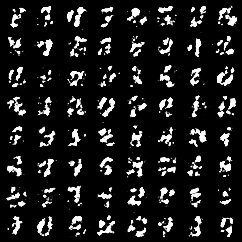

**********
Epoch: 1
Generator_Loss: -4768.794354572892
Discrimitor_Loss: -136.81924858689308


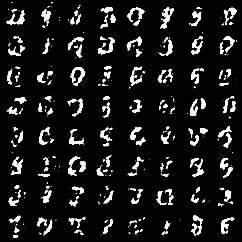

**********
Epoch: 2
Generator_Loss: -3406.4256820976734
Discrimitor_Loss: -106.06548037752509


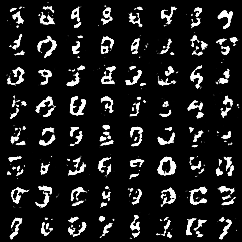

**********
Epoch: 3
Generator_Loss: -2418.348650773056
Discrimitor_Loss: -214.5969755873084


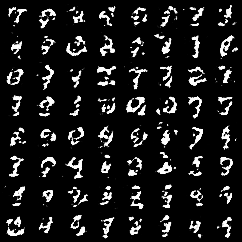

**********
Epoch: 4
Generator_Loss: -2062.5916987191886
Discrimitor_Loss: -210.064029045403


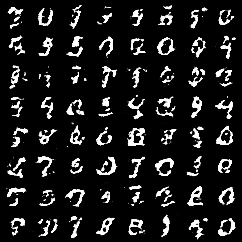

**********
Epoch: 5
Generator_Loss: -1863.8782804484945
Discrimitor_Loss: -202.18645311892033


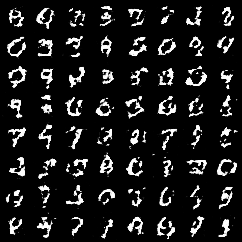

**********
Epoch: 6
Generator_Loss: -1596.7875301779713
Discrimitor_Loss: -179.8520091921091


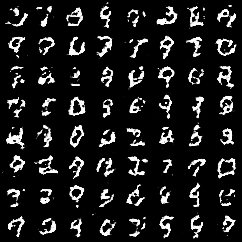

**********
Epoch: 7
Generator_Loss: -1513.6719542637002
Discrimitor_Loss: -160.13200658746064


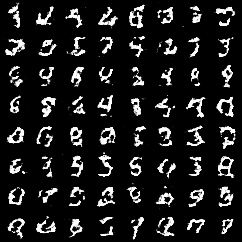

**********
Epoch: 8
Generator_Loss: -1547.309840388596
Discrimitor_Loss: -153.96206145733595


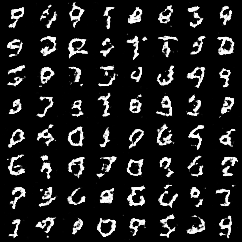

**********
Epoch: 9
Generator_Loss: -1455.6317862938158
Discrimitor_Loss: -132.18132082745433


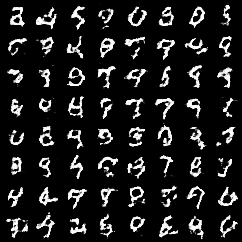

In [15]:
# Training

for epoch in range(EPOCHES):
    print('*'*10)
    print('Epoch: {}'.format(epoch))
    d_tloss = 0.0
    g_tloss = 0.0
    d_taccu = 0.0
    for i, data in enumerate(train_loader):
        img, labels = data
        data_num = img.size(0)
#         img = img.view(data_num, -1)
        
        x_real = Variable(img)
        x_fake = Variable(torch.randn(data_num, NOISE_DIM))
        y_real = Variable(torch.ones(data_num))
        y_fake = Variable(torch.zeros(data_num))
        if torch.cuda.is_available():
            x_real = x_real.cuda()
            x_fake = x_fake.cuda()
            y_real = y_real.cuda()
            y_fake = y_fake.cuda()
    
        for p in d_model.parameters():
            p.requires_grad = True
        d_out_real = d_model(x_real)
        d_loss_real = criterion(d_out_real, y_real)
        g_out_fake = g_model(x_fake)
        d_out_fake = d_model(g_out_fake.detach())
#         d_loss_fake = criterion(d_out_fake, y_fake)
#         d_loss = d_loss_real + d_loss_fake
        d_loss = (torch.mean(d_out_real) - torch.mean(d_out_fake))
        d_tloss += d_loss.data[0]

        d_optim.zero_grad()
        d_loss.backward()
        d_optim.step()
        for p in d_model.parameters():
            p.data.clamp_(-0.01, 0.01)

        for p in d_model.parameters():
            p.requires_grad = False
        g_out_fake = g_model(x_fake)
        d_out_fake = d_model(g_out_fake)
#         g_loss = criterion(d_out_fake, y_real)
        g_loss = torch.mean(d_out_fake)
        g_tloss += g_loss.data[0]
        d_optim.zero_grad()
        g_optim.zero_grad()
        g_loss.backward()
        g_optim.step()
    print('Generator_Loss: {}'.format(g_tloss))
    print('Discrimitor_Loss: {}'.format(d_tloss))
    check_generator(g_model)